# 1. Improting data an neccesary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from visualizations import *
import warnings
from math import tau
from scipy.integrate import quad
from skimage import io
from skimage.transform import resize
from transform_digit import *
warnings.filterwarnings('ignore')

C:\Users\01121832\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2


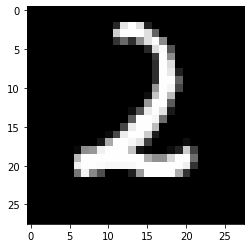

In [2]:
data = np.loadtxt("../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("../DATA/digits2k_pixels.labels.gz", dtype='int')
# display:
i = 122
print(labels[i])
plt.imshow(data[i,:,:], cmap=plt.get_cmap("gray"))
plt.show()

# 2. Concept

The aim of this project was to find a way to use clustering algorithms to distinguish digits from MNIST dataset. Firstly we decided to visualise our dataset using both PCA and t-SNE. Then we considered using PCA to reduce dimensions however we ended up with totally different approach. We changed all values in matrix to 1 or 0 (all pixels in a digit to black or white). Then we used a function to find a cantour of such a digit. Then we approximated the contour with Fourier Transform, which resulted in having list of certain number of points belonging to the countour. Finally such points were compared between the images and on such preproccesed dataset clustering algorhitms were run.

# 3. Exploratory Data Analysis

Hence our dataset is original and different from others it's difficult to do regular EDA. However we can somehow try to get know the dataset we are dealing with by visualising it. MNIST dataset consists of 2k images, each of them is 28x28 pixels. So that gives us the dataset which has a shape of (2000, 784). It's a lot of data and proceeding on such a high dimensionality dataset can be very time consuming. MNIST data points are embedded in 784-dimensional space, however they live in a very small subspace. We can observe it by this example.

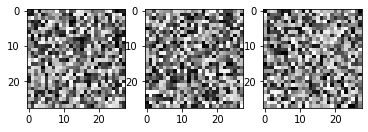

In [3]:
random1 = np.random.uniform(low=0, high=1, size=(28,28))
random2 = np.random.uniform(low=0, high=1, size=(28,28))
random3 = np.random.uniform(low=0, high=1, size=(28,28))

fig, ax = plt.subplots(1,3)
ax[0].imshow(random1, cmap=plt.get_cmap("gray"))
ax[1].imshow(random2, cmap=plt.get_cmap("gray"))
ax[2].imshow(random3, cmap=plt.get_cmap("gray"))

These images look nothing like mnist numbers - even though they both are embedded in 784 - dimensional space. That's why it is said that MNIST has a lowe dimensional strcuture. The most popular method of reducing dimension is PCA.

## 3.1. PCA approach

PCA was widely described on our labs, so we won't go into details here.

### 3.1.1. Data preprocessing

Firstly, let's modify our dataset to 2-dimensional array so it has shape of (60000, 784) as it was mentioned earlier.


In [4]:
data_reshaped = data.reshape(2000, 28*28)

In order for PCA to be efficient every variable of data has to be standard scaled (mean = 0, devaiation = 1)

In [5]:
standardized_data = StandardScaler().fit_transform(data_reshaped)
sample_data = standardized_data

### 3.1.2. Possible dimension reduction

By plotting Cumulative explained varaince we can examine to what number of dimensions can we reduce our dataset without losing too much information.

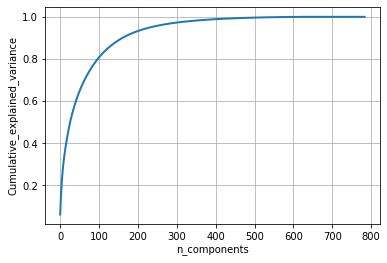

In [6]:
# initializing the pca
pca = decomposition.PCA()
pca.n_components = 784

lol = pca.fit(sample_data)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# If we take 200-dimensions, approx. 90% of variance is expalined.


### 3.1.3. PCA components

Below are presented principial components, visualised as MNIST numbers images. They explain how do we distinguish the digits in current dimension.

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

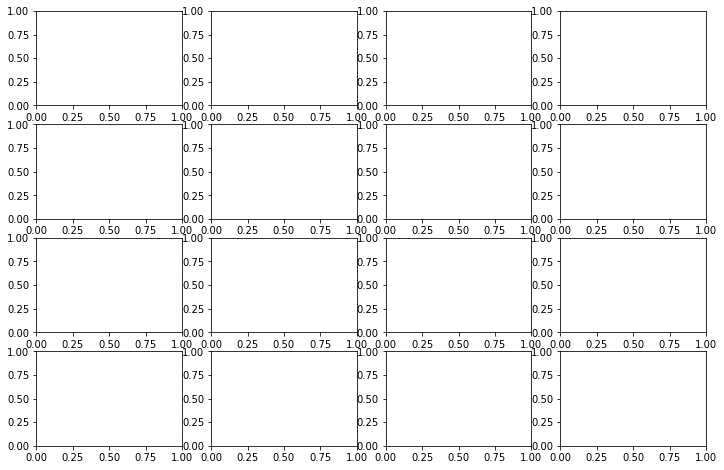

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))

k = 0
for i in range(4):
    for j in range(4):
        sns.heatmap(pca.components_[k, :].reshape(28, 28), ax = axes[i][j],
                    cmap = sns.diverging_palette(240, 10, n=20))
        axes[i][j].set_title(
            "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[k]*100),
            fontsize=12)
        axes[i][j].set_aspect('equal')
        axes[i][j].axis('off')
        k += 1


plt.suptitle('16-Component PCA')

### 3.1.4. PCA 2-dim visualisation

Not only can we reduce the dimensions, but also use PCA to visualise our dataset.

In [8]:
covar_matrix = np.matmul(sample_data.T , sample_data)
# finding the top two eigen-values and corresponding eigen-vectors 
# for projecting onto a 2-Dim space.

from scipy.linalg import eigh 

# eigh function will return the eigen values in asending order
# this code generates only the top 2 (782 and 783)(index) eigenvalues.
values, vectors = eigh(covar_matrix, eigvals=(782,783))
vectors = vectors.T
# here the vectors[1] represent the eigen vector corresponding 1st principal eigen vector
# here the vectors[0] represent the eigen vector corresponding 2nd principal eigen vector

new_coordinates = np.matmul(vectors, sample_data.T)

# appending label to the 2d projected data(vertical stack)
new_coordinates = np.vstack((new_coordinates, labels)).T
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))
print(dataframe.head())

   1st_principal  2nd_principal  label
0       3.885769       0.420347    5.0
1       6.513312      -9.226496    0.0
2      -9.116109      -2.220315    4.0
3       2.773206       7.376189    1.0
4      -3.844514       4.831797    9.0


Below we have interactive plot, but the colours are not easy distinguishable, so there is one more plot below.

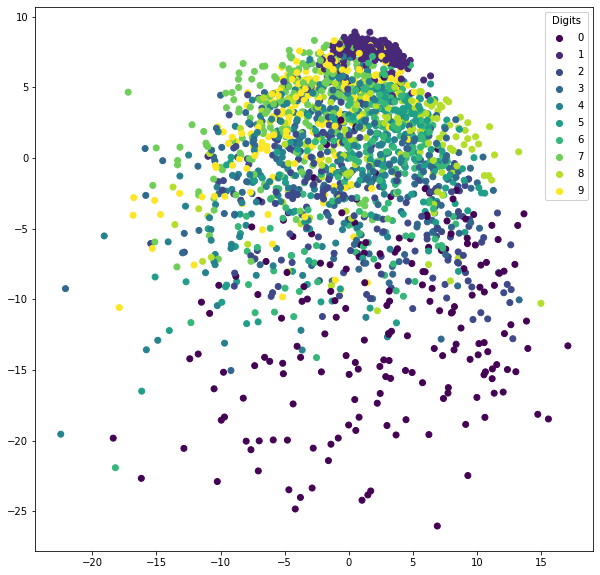

In [9]:
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np; np.random.seed(42)

# Generate data x, y for scatter and an array of images.
x = dataframe["1st_principal"]
y = dataframe["2nd_principal"]
arr = np.empty((len(x),28,28))
for i in range(len(x)):
    arr[i,:,:] = sample_data[i].reshape(28, 28)

# create figure and plot scatter
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
colors = dataframe["label"].to_numpy().astype(int)
line = ax.scatter(x,y, c = colors)

# create the annotations box
im = OffsetImage(arr[0,:,:], zoom=5, cmap = plt.get_cmap("gray"))
xybox=(50., 50.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):
    # if the mouse is over the scatter points
    if line.contains(event)[0]:
        # find out the index within the array from the event
        ind, = line.contains(event)[1]["ind"]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        # place it at the position of the hovered scatter point
        ab.xy =(x[ind], y[ind])
        # set the image corresponding to that point
        im.set_data(arr[ind,:,:])
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)
legend1 = ax.legend(*line.legend_elements(),
                    loc = "upper right", title = "Digits")
ax.add_artist(legend1)
plt.show()

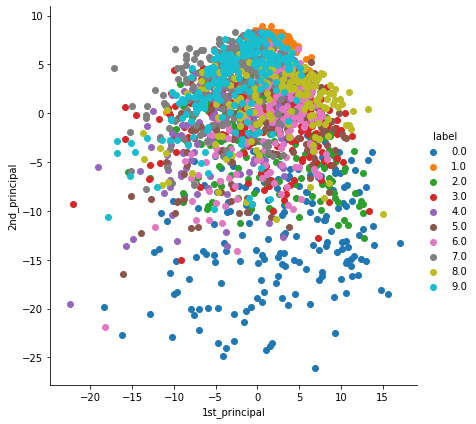

In [10]:
sns.FacetGrid(dataframe, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

We can see that visualising this dataset in 2 dimensions is far from perfect, however it is at least something.

## 3.2. t-SNE approach


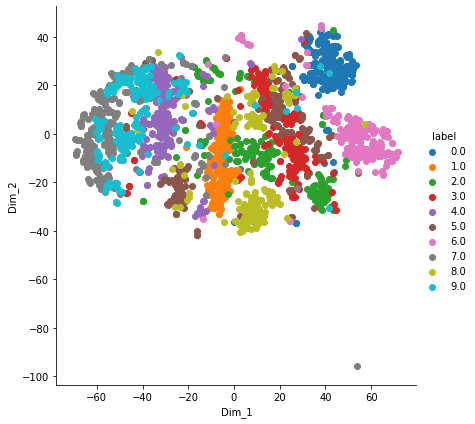

In [11]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sample_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

We can see that t-SNE managed to seperate clusters on a 2-dim visualisation much better than PCA. Moreover the result could be even better by tuning ``n_components`` and ``perplexity`` parametres. We won't do it, because it's just the tool for the sake of visualisation and eventually it turned out that we won't use it in further analysis.

# 4. Preprocessing

Whole preprocessing is thoroughly described in FourierMethodSummary.ipynb notebook. To conclude we changed all values in matrix to 1 or 0 (all pixels in a digit to black or white). Then we used a function to find a cantour of such a digit. Then we approximated the contour with Fourier Transform, which resulted in having list of certain number of points belonging to the countour.

# 5. Clustering

We decided to use multiple clustering methods on such preproccesed dataset in order to find the one that is having the highest scores in evaluation metrics, which we described below.

In [12]:
#Centroid distances upload:
centroid_distances = np.load('centroid_distances_N_50.npy')

## 5.1. Functions to determine scores
These two functions simply are used to assign labels to many clusters. Assigned labels are based on dominant true label (taken from dataset) in a cluster.

In [13]:
def determineClusterDigit(labels_true, labels_pred, cluster_num):
    real_labels, counts = np.unique(labels[labels_pred == cluster_num], return_counts=True)
    if len(real_labels) == 0:
        return -1
    return real_labels[np.argmax(counts)]

def assignRealLabels(labels_pred, labels_true):
    label_mapping = dict()
    n_clusters = max(labels_pred)+1
    for i in range(n_clusters):
        label_mapping[i] = determineClusterDigit(labels_true, labels_pred, i)
    
    labels_final_prediction = pd.Series(labels_pred)
    labels_final_prediction = labels_final_prediction.map(label_mapping)
    return labels_final_prediction, label_mapping

This function returns a precision for all possible labels and an average precision score.

In [14]:
# Precision one vs all
def calcPrecision(labels_true, labels_final_prediction):
    digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    precisions = []
    sum_all = 0
    for d in digits:
        all_d = 0
        good_d = 0
        for i in range(len(labels_true)):
            if labels_true[i] == d:
                all_d += 1
                if labels_final_prediction[i] == d:
                    good_d += 1
        precisions.append( (d, good_d/all_d) )
        sum_all += good_d/all_d
    precisions.append( ('average', sum_all/10) )
    return precisions

## 5.2. Ward model 

In [15]:
from sklearn.cluster import AgglomerativeClustering

In [16]:
model = AgglomerativeClustering(n_clusters = 70)
model.fit(centroid_distances)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=70,
                        pooling_func='deprecated')

In [17]:
labels_pred = model.labels_
n_clusters = max(model.labels_)
labels_final_prediction, label_mapping = assignRealLabels(labels_pred, labels)

In [18]:
calcPrecision(labels, labels_final_prediction)

[(0, 0.9057591623036649),
 (1, 0.9545454545454546),
 (2, 0.6666666666666666),
 (3, 0.8952879581151832),
 (4, 0.9205607476635514),
 (5, 0.6666666666666666),
 (6, 0.885),
 (7, 0.7098214285714286),
 (8, 0.6162790697674418),
 (9, 0.7142857142857143),
 ('average', 0.7934872868585773)]

## 5.3. Affinity model

In [19]:
from sklearn.cluster import AffinityPropagation

In [20]:
model = AffinityPropagation()
model.fit(centroid_distances)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

In [21]:
max(model.labels_)

89

In [22]:
labels_pred = model.labels_
n_clusters = max(model.labels_)
labels_final_prediction, label_mapping = assignRealLabels(labels_pred, labels)

In [23]:
calcPrecision(labels, labels_final_prediction)

[(0, 0.9267015706806283),
 (1, 0.9727272727272728),
 (2, 0.51010101010101),
 (3, 0.837696335078534),
 (4, 0.8925233644859814),
 (5, 0.5444444444444444),
 (6, 0.92),
 (7, 0.7410714285714286),
 (8, 0.6976744186046512),
 (9, 0.8047619047619048),
 ('average', 0.7847701749455855)]

## 5.4. Analysing clusters

Let's check for example differences between clusters of 7s

In [34]:
clusters_of_7 = []
for i in range(max(model.labels_)):
    if label_mapping[i] == 7:
        clusters_of_7.append(i)

In [39]:
clusters_of_7

[12, 20, 54, 57, 59, 65, 70, 73, 75, 80]

Function needed to display sample of clusters

In [77]:
def DisplaySampleOfDigit(cluster, n=10):
    positions_of_digit = np.where(labels_pred == cluster)
    positions_of_digit = positions_of_digit[0] # upper function returned a tuple
    # random selection of n positions
    np.random.shuffle(positions_of_digit)
    positions_to_use = positions_of_digit[0:n]
    # setting up image display
    fig, axs = plt.subplots(1, n, figsize=(20, 20))
    
    for i in range(n):
        axs[i].imshow(data[positions_to_use[i],:,:], cmap=plt.get_cmap("gray"))
        axs[i].axis('off')

### Cluster 12 (of 7)

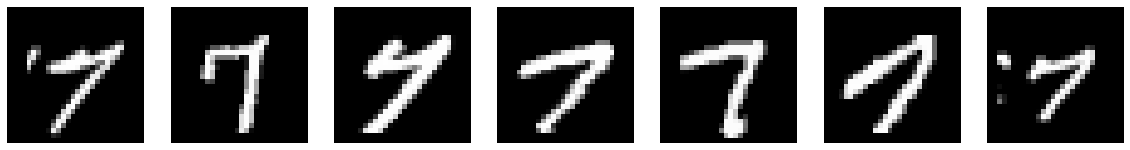

In [109]:
DisplaySampleOfDigit(12, n=7)

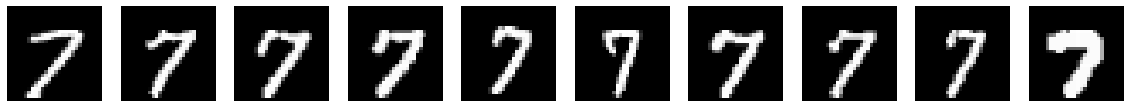

In [108]:
DisplaySampleOfDigit(20, n=10)

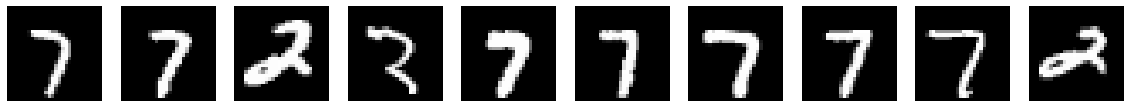

In [107]:
DisplaySampleOfDigit(54, n=10)

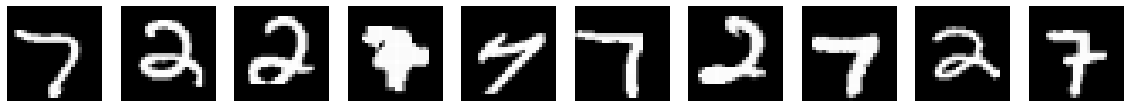

In [106]:
DisplaySampleOfDigit(57, n=10)

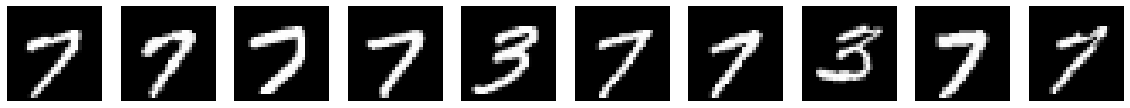

In [102]:
DisplaySampleOfDigit(59, n=10)

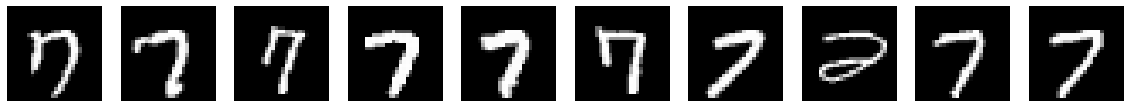

In [98]:
DisplaySampleOfDigit(65, n=10)

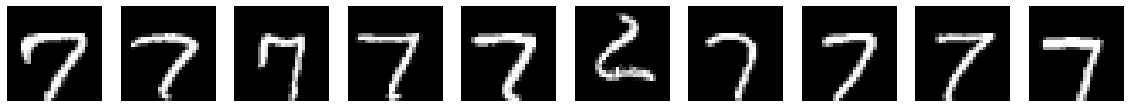

In [97]:
DisplaySampleOfDigit(70, n=10)

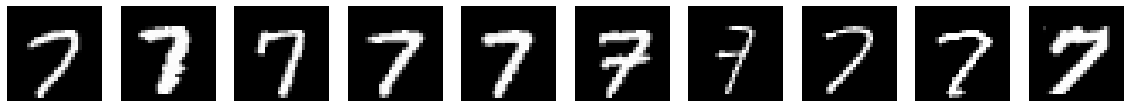

In [91]:
DisplaySampleOfDigit(73, n=10)

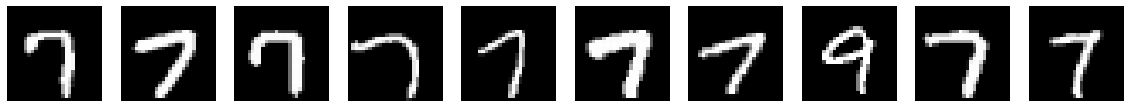

In [95]:
DisplaySampleOfDigit(75, n=10)

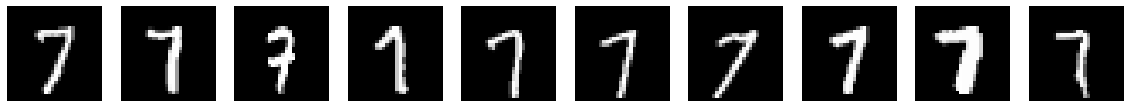

In [93]:
DisplaySampleOfDigit(80, n=10)

## 5.5. Predicting custom digit

We also included a feature, where we can write down our own number (for example in paint) and then check how the best of the algorithms above classifies it.

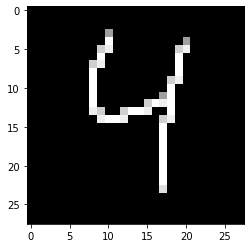

In [181]:
plt.close()
painted = io.imread("./test_new.png", as_grey=True)
plt.imshow(painted, cmap=plt.get_cmap("gray"))

In [182]:
centr_distances_test = transformToDistances(painted)
plt.close()
primal_label = model.predict([centr_distances_test])[0]
primal_label

62

In [183]:
true_label = label_mapping[primal_label]
true_label

4

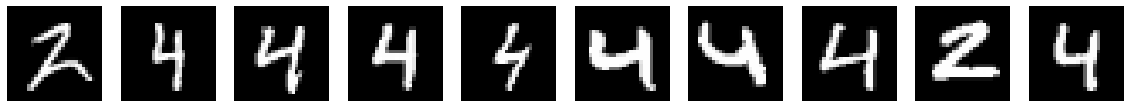

In [184]:
DisplaySampleOfDigit(62, n=10)